In [2]:
import pandas as pd
import open3d as o3d
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import skewtest
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import random
from sklearn.model_selection import train_test_split

In [3]:
# Import data
df = pd.read_csv('plant_height.csv', converters={'Record': str, 'plot_id':str})

# Set new column names
df['sensor_height'] = np.nan
df['error'] = np.nan
df['physical_height'] = df['Height (cm)']/100

In [4]:
print(df.tail())

   Record         Trial Collection Date Collection Level  Height (cm) plot_id  \
45     06  Garden Plots       8/12/2023            Plant          145      06   
46     01  Garden Plots       8/12/2023            Plant          123      01   
47     16  Garden Plots       8/12/2023            Plant          117      16   
48     19  Garden Plots       8/12/2023            Plant          121      19   
49     20  Garden Plots       8/12/2023            Plant          126      20   

               date_dir     trial_dir  sensor_height  error  physical_height  
45  Sampling_08_12_2023  Garden_Plots            NaN    NaN             1.45  
46  Sampling_08_12_2023  Garden_Plots            NaN    NaN             1.23  
47  Sampling_08_12_2023  Garden_Plots            NaN    NaN             1.17  
48  Sampling_08_12_2023  Garden_Plots            NaN    NaN             1.21  
49  Sampling_08_12_2023  Garden_Plots            NaN    NaN             1.26  


In [5]:
# Get sensor plant height
def get_sensor_height(row):
    
    # set directory
    inf='{a}\{b}\{c}\sor_plant_{d}.ply'.format(a=row['trial_dir'],
                                            b=row['date_dir'],
                                            c=row['plot_id'],
                                            d=row['Record'])
    
    # Read file
    pcd = o3d.io.read_point_cloud(inf)

    # Get points
    points = np.asarray(pcd.points)

    # Get height
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    sensor_height = max_coords[2] - min_coords[2]

    # Add row values
    row['sensor_height'] = sensor_height
    row['error'] = sensor_height - row['physical_height']

    return row

In [6]:
# Apply function to df
df = df.apply(get_sensor_height, axis=1)

In [7]:
# Add a percent error column
df['percent_error'] = df['error'] / df['physical_height'] * 100

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Record            50 non-null     object 
 1   Trial             50 non-null     object 
 2   Collection Date   50 non-null     object 
 3   Collection Level  50 non-null     object 
 4   Height (cm)       50 non-null     int64  
 5   plot_id           50 non-null     object 
 6   date_dir          50 non-null     object 
 7   trial_dir         50 non-null     object 
 8   sensor_height     50 non-null     float64
 9   error             50 non-null     float64
 10  physical_height   50 non-null     float64
 11  percent_error     50 non-null     float64
dtypes: float64(4), int64(1), object(7)
memory usage: 4.8+ KB
None


In [9]:
print(df.head())

  Record                    Trial Collection Date Collection Level  \
0  10171  Tomato Fertilizer Trial       8/10/2023            Plant   
1  10172  Tomato Fertilizer Trial       8/10/2023            Plant   
2  10173  Tomato Fertilizer Trial       8/10/2023            Plant   
3  10261  Tomato Fertilizer Trial       8/10/2023            Plant   
4  10262  Tomato Fertilizer Trial       8/10/2023            Plant   

   Height (cm) plot_id             date_dir                trial_dir  \
0           67    1017  Sampling_08_10_2023  Tomato_Fertilizer_Trial   
1           71    1017  Sampling_08_10_2023  Tomato_Fertilizer_Trial   
2           65    1017  Sampling_08_10_2023  Tomato_Fertilizer_Trial   
3           69    1026  Sampling_08_10_2023  Tomato_Fertilizer_Trial   
4           68    1026  Sampling_08_10_2023  Tomato_Fertilizer_Trial   

   sensor_height   error  physical_height  percent_error  
0         0.6456 -0.0244             0.67      -3.641788  
1         0.6656 -0.0444    

In [10]:
# root mean squared error function
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [11]:
# relative root mean squared error function
def rrmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())/targets.mean()

In [12]:
# rmse tomato fertilizer trial
tfdf = df[df['trial_dir'] == 'Tomato_Fertilizer_Trial']
tfrmse = rmse(tfdf['sensor_height'], tfdf['physical_height'])
tfrrmse = rrmse(tfdf['sensor_height'], tfdf['physical_height'])
print('Tomato Fertilizer Trial RMSE: {}'.format(tfrmse))
print('Tomato Fertilizer Trial RRMSE: {}'.format(tfrrmse))

Tomato Fertilizer Trial RMSE: 0.06555178433708392
Tomato Fertilizer Trial RRMSE: 0.09065442680795273


In [13]:
# rmse garden plots
gpdf = df[df['trial_dir'] == 'Garden_Plots']
gprmse = rmse(gpdf['sensor_height'], gpdf['physical_height'])
gprrmse = rrmse(gpdf['sensor_height'], gpdf['physical_height'])
print('Garden Plots RMSE: {}'.format(gprmse))
print('Garden Plots RRMSE: {}'.format(gprrmse))

Garden Plots RMSE: 0.15691098876502166
Garden Plots RRMSE: 0.14445200346607287


In [14]:
# total rmse
trmse = rmse(df['sensor_height'], df['physical_height'])
trrmse = rrmse(df['sensor_height'], df['physical_height'])
print('Total RMSE: {}'.format(trmse))
print('Total RRMSE: {}'.format(trrmse))

Total RMSE: 0.08688429054924802
Total RRMSE: 0.11121900991967233


In [15]:
# mape tomato fertilizer trial
tfmape = mean_absolute_percentage_error(tfdf['sensor_height'], tfdf['physical_height'])
print('Tomato Fertilizer Trial MAPE: {}'.format(tfmape))

Tomato Fertilizer Trial MAPE: 0.06664322877149231


In [16]:
# mape garden plots
gpmape = mean_absolute_percentage_error(gpdf['sensor_height'], gpdf['physical_height'])
print('Garden Plots MAPE: {}'.format(gpmape))

Garden Plots MAPE: 0.12704604238220685


In [17]:
# total mape
mape = mean_absolute_percentage_error(df['sensor_height'], df['physical_height'])
print('Total MAPE: {}'.format(mape))

Total MAPE: 0.07630767894920663


In [18]:
# mean sensor height
mean_sensor_height = df['sensor_height'].mean()
print('Total Mean Sensor Height: {}'.format(mean_sensor_height))
tf_mean_sensor_height = tfdf['sensor_height'].mean()
print('Tomato Fertilizer Trial Mean Sensor Height: {}'.format(tf_mean_sensor_height))
gp_mean_sensor_height = gpdf['sensor_height'].mean()
print('Garden Plots Mean Sensor Height: {}'.format(gp_mean_sensor_height))

Total Mean Sensor Height: 0.7648980000356096
Tomato Fertilizer Trial Mean Sensor Height: 0.7034595240301791
Garden Plots Mean Sensor Height: 1.0874499990641198


In [19]:
# mean physical height
mean_physical_height = df['physical_height'].mean()
print('Mean Physical Height: {}'.format(mean_physical_height))
tf_mean_physical_height = tfdf['physical_height'].mean()
print('Tomato Fertilizer Trial Mean Physical Height: {}'.format(tf_mean_physical_height))
gp_mean_physical_height = gpdf['physical_height'].mean()
print('Garden Plots Mean Physical Height: {}'.format(gp_mean_physical_height))

Mean Physical Height: 0.7812
Tomato Fertilizer Trial Mean Physical Height: 0.7230952380952381
Garden Plots Mean Physical Height: 1.08625


In [20]:
# difference
difference = abs(mean_sensor_height - mean_physical_height)
print('Difference: {}'.format(difference))
tf_difference = abs(tf_mean_sensor_height - tf_mean_physical_height)
print('Tomato Fertilizer Trial Difference: {}'.format(tf_difference))
gp_difference = abs(gp_mean_sensor_height - gp_mean_physical_height)
print('Garden Plots Difference: {}'.format(gp_difference))

Difference: 0.016301999964390412
Tomato Fertilizer Trial Difference: 0.01963571406505904
Garden Plots Difference: 0.0011999990641198277


In [21]:
# mean percent difference
mean_percent_difference = difference / mean_physical_height*100
print('Mean Percent Difference: {}'.format(mean_percent_difference))
tf_mean_percent_difference = tf_difference / tf_mean_physical_height*100
print('Tomato Fertilizer Trial Mean Percent Difference: {}'.format(tf_mean_percent_difference))
gp_mean_percent_difference = gp_difference / gp_mean_physical_height*100
print('Garden Plots Mean Percent Difference: {}'.format(gp_mean_percent_difference))

Mean Percent Difference: 2.086789549973171
Tomato Fertilizer Trial Mean Percent Difference: 2.715508695200789
Garden Plots Mean Percent Difference: 0.11047172051736043


In [22]:
# Drop columns
df.drop(columns=['Height (cm)'], inplace=True)

In [23]:
# save df to	csv
df.to_csv('plant_height_comparisons.csv', index=False)

# Determining Whether Trials Are Statistically Different

First, let us confirm that plant height is different between trials.

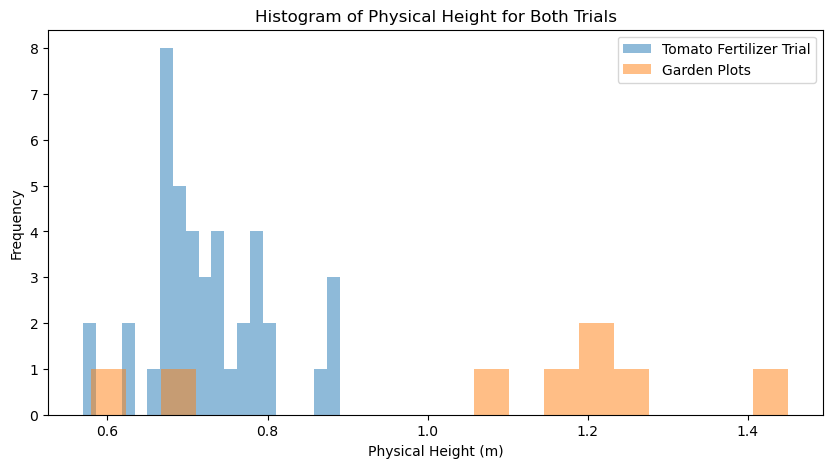

In [24]:
# Plot histogram of physical height for both trials
plt.figure(figsize=(10, 5))
plt.hist(tfdf['physical_height'], bins=20, alpha=0.5, label='Tomato Fertilizer Trial')
plt.hist(gpdf['physical_height'], bins=20, alpha=0.5, label='Garden Plots')
plt.xlabel('Physical Height (m)')
plt.ylabel('Frequency')
plt.title('Histogram of Physical Height for Both Trials')
plt.legend()

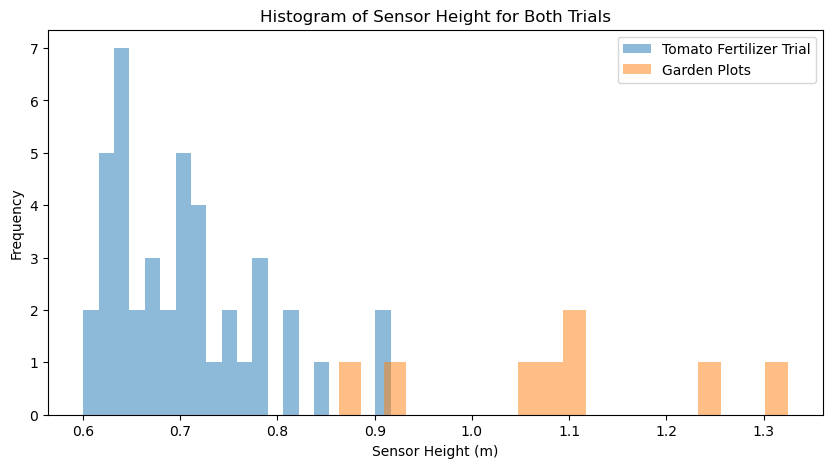

In [25]:
# Plot histogram for sensor height for both trials
plt.figure(figsize=(10, 5))
plt.hist(tfdf['sensor_height'], bins=20, alpha=0.5, label='Tomato Fertilizer Trial')
plt.hist(gpdf['sensor_height'], bins=20, alpha=0.5, label='Garden Plots')
plt.xlabel('Sensor Height (m)')
plt.ylabel('Frequency')
plt.title('Histogram of Sensor Height for Both Trials')
plt.legend()
plt.show()

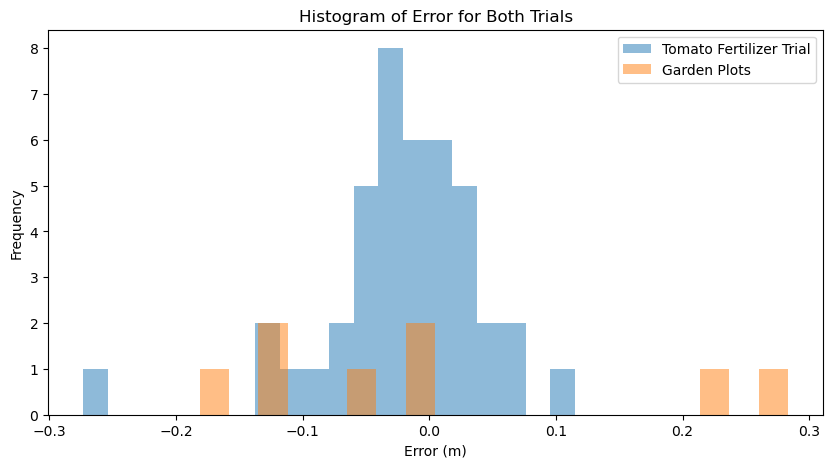

In [26]:
# Plot a histogram of the error for both trials
plt.figure(figsize=(10, 5))
plt.hist(tfdf['error'], bins=20, alpha=0.5, label='Tomato Fertilizer Trial')
plt.hist(gpdf['error'], bins=20, alpha=0.5, label='Garden Plots')
plt.xlabel('Error (m)')
plt.ylabel('Frequency')
plt.title('Histogram of Error for Both Trials')
plt.legend()
plt.show()

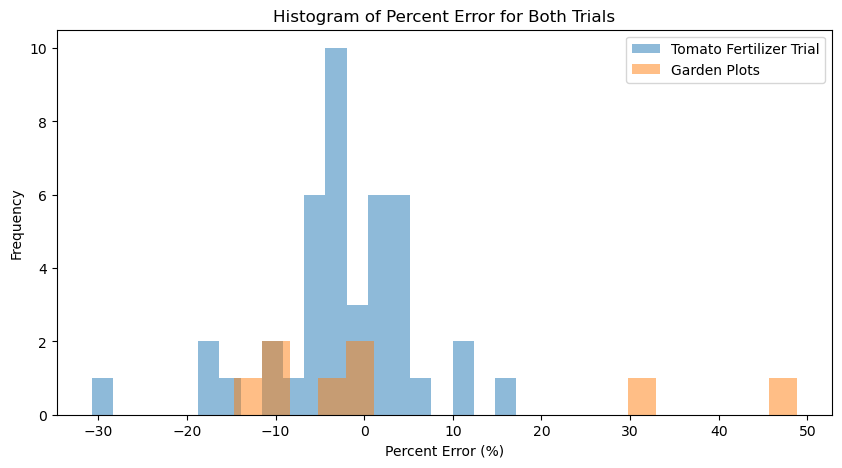

In [27]:
# Plot a histogram of the percent error for both trials
plt.figure(figsize=(10, 5))
plt.hist(tfdf['percent_error'], bins=20, alpha=0.5, label='Tomato Fertilizer Trial')
plt.hist(gpdf['percent_error'], bins=20, alpha=0.5, label='Garden Plots')
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Percent Error for Both Trials')
plt.legend()
plt.show()

Normality and skewness will now be tested.

In [28]:
# Check normality of the physical height distribution using Shapiro-Wilk test
shapiro_tf = shapiro(tfdf['physical_height'])
shapiro_gp = shapiro(gpdf['physical_height'])
print('Shapiro-Wilk test for Tomato Fertilizer Trial: W = {}, p-value = {}'.format(shapiro_tf.statistic, shapiro_tf.pvalue))
print('Shapiro-Wilk test for Garden Plots: W = {}, p-value = {}'.format(shapiro_gp.statistic, shapiro_gp.pvalue))
# Run skewness test
skew_tf = skewtest(tfdf['physical_height'])
skew_gp = skewtest(gpdf['physical_height'])
print('Skewness test for Tomato Fertilizer Trial: statistic = {}, p-value = {}'.format(skew_tf.statistic, skew_tf.pvalue))
print('Skewness test for Garden Plots: statistic = {}, p-value = {}'.format(skew_gp.statistic, skew_gp.pvalue))

Shapiro-Wilk test for Tomato Fertilizer Trial: W = 0.9533002376556396, p-value = 0.08483478426933289
Shapiro-Wilk test for Garden Plots: W = 0.8649817705154419, p-value = 0.13454896211624146
Skewness test for Tomato Fertilizer Trial: statistic = 1.374728475049897, p-value = 0.16921563981293453
Skewness test for Garden Plots: statistic = -1.2916166595000578, p-value = 0.19648993179812602


In [29]:
# Check normality of the sensed height distribution using Shapiro-Wilk test
shapiro_tf_sensor = shapiro(tfdf['sensor_height'])
shapiro_gp_sensor = shapiro(gpdf['sensor_height'])
print('Shapiro-Wilk test for Tomato Fertilizer Trial Sensor Height: W = {}, p-value = {}'.format(shapiro_tf_sensor.statistic, shapiro_tf_sensor.pvalue))
print('Shapiro-Wilk test for Garden Plots Sensor Height: W = {}, p-value = {}'.format(shapiro_gp_sensor.statistic, shapiro_gp_sensor.pvalue))
# Run skewness test
skew_tf_sensor = skewtest(tfdf['sensor_height'])
skew_gp_sensor = skewtest(gpdf['sensor_height'])
print('Skewness test for Tomato Fertilizer Trial Sensor Height: statistic = {}, p-value = {}'.format(skew_tf_sensor.statistic, skew_tf_sensor.pvalue))
print('Skewness test for Garden Plots Sensor Height: statistic = {}, p-value = {}'.format(skew_gp_sensor.statistic, skew_gp_sensor.pvalue))

Shapiro-Wilk test for Tomato Fertilizer Trial Sensor Height: W = 0.910382866859436, p-value = 0.0029890078585594893
Shapiro-Wilk test for Garden Plots Sensor Height: W = 0.9563716053962708, p-value = 0.7749159932136536
Skewness test for Tomato Fertilizer Trial Sensor Height: statistic = 2.701323854642976, p-value = 0.006906405261363715
Skewness test for Garden Plots Sensor Height: statistic = 0.06035664535487765, p-value = 0.951871587665168


In [30]:
# Check normality of the error distribution using Shapiro-Wilk test
shapiro_tf = shapiro(tfdf['error'])
print('Shapiro-Wilk test for Tomato Fertilizer Trial: W = {}, p-value = {}'.format(shapiro_tf.statistic, shapiro_tf.pvalue))
shapiro_gp = shapiro(gpdf['error'])
print('Shapiro-Wilk test for Garden Plots: W = {}, p-value = {}'.format(shapiro_gp.statistic, shapiro_gp.pvalue))
# Run skewness test
skew_tf = skewtest(tfdf['error'])
skew_gp = skewtest(gpdf['error'])
print('Skewness test for Tomato Fertilizer Trial: statistic = {}, p-value = {}'.format(skew_tf.statistic, skew_tf.pvalue))
print('Skewness test for Garden Plots: statistic = {}, p-value = {}'.format(skew_gp.statistic, skew_gp.pvalue))

Shapiro-Wilk test for Tomato Fertilizer Trial: W = 0.891191303730011, p-value = 0.0007928083650767803
Shapiro-Wilk test for Garden Plots: W = 0.8711875081062317, p-value = 0.1548088937997818
Skewness test for Tomato Fertilizer Trial: statistic = -3.5461178801119884, p-value = 0.0003909512807984794
Skewness test for Garden Plots: statistic = 1.2910887108747013, p-value = 0.19667291818379973


In [31]:
# Check normality of the percent error distribution using Shapiro-Wilk test
shapiro_tf = shapiro(tfdf['percent_error'])
print('Shapiro-Wilk test for Tomato Fertilizer Trial: W = {}, p-value = {}'.format(shapiro_tf.statistic, shapiro_tf.pvalue))
shapiro_gp = shapiro(gpdf['percent_error'])
print('Shapiro-Wilk test for Garden Plots: W = {}, p-value = {}'.format(shapiro_gp.statistic, shapiro_gp.pvalue))
# Run skewness test
skew_tf = skewtest(tfdf['percent_error'])
skew_gp = skewtest(gpdf['percent_error'])
print('Skewness test for Tomato Fertilizer Trial: statistic = {}, p-value = {}'.format(skew_tf.statistic, skew_tf.pvalue))
print('Skewness test for Garden Plots: statistic = {}, p-value = {}'.format(skew_gp.statistic, skew_gp.pvalue))

Shapiro-Wilk test for Tomato Fertilizer Trial: W = 0.9425195455551147, p-value = 0.035019923001527786
Shapiro-Wilk test for Garden Plots: W = 0.7858952879905701, p-value = 0.02018136903643608
Skewness test for Tomato Fertilizer Trial: statistic = -2.1383119184696646, p-value = 0.0324914358800279
Skewness test for Garden Plots: statistic = 1.868932350738392, p-value = 0.061632226778565426


Recap:
1. Physical height: TF normal symmetrical dist, GP normal symmetrical dist
2. Sensed height: TF abnormal asymmetrical dist, GP normal symmetrical dist
3. Error: TF abnormal asymmetrical dist, GP abnormal symmetrical dist
4. Percent error: TF abnormal asymmetrical dist, GP abnormal symmetrical dist

This means we can run a t-test to prove that the physical heights are different, but we cannot do that for the other ones because it violates the assumption of normality (which also typically includes a symmetrical distribution). Let us prove the heights are different.

In [32]:
# run a t-test for the physical height of the two trials
t_stat, p_value = ttest_ind(tfdf['physical_height'], gpdf['physical_height'], equal_var=False)
print('T-test for Physical Height: t-statistic = {}, p-value = {}'.format(t_stat, p_value))

T-test for Physical Height: t-statistic = -3.433969035575104, p-value = 0.010537008383426987


They are indeed different in height. We can do a Mann-Whitney U test to compare the other distributions.

In [33]:
# run a mann-whitney u test for the sensor height of the two trials
u_stat, p_value = mannwhitneyu(tfdf['sensor_height'], gpdf['sensor_height'], alternative='two-sided')
print('Mann-Whitney U test for Sensor Height: U-statistic = {}, p-value = {}'.format(u_stat, p_value))
# run a mann-whitney u test for the error of the two trials
u_stat, p_value = mannwhitneyu(tfdf['error'], gpdf['error'], alternative='two-sided')
print('Mann-Whitney U test for Error: U-statistic = {}, p-value = {}'.format(u_stat, p_value))
# run a mann-whitney u test for the percent error of the two trials
u_stat, p_value = mannwhitneyu(tfdf['percent_error'], gpdf['percent_error'], alternative='two-sided')
print('Mann-Whitney U test for Percent Error: U-statistic = {}, p-value = {}'.format(u_stat, p_value))

Mann-Whitney U test for Sensor Height: U-statistic = 3.0, p-value = 1.3414252320863416e-05
Mann-Whitney U test for Error: U-statistic = 192.0, p-value = 0.5410715065685701
Mann-Whitney U test for Percent Error: U-statistic = 175.0, p-value = 0.8660473423556703


Sensed height differs between the two trials, but error and percent error does not. It makes sense, as the plants were definitely different in height, so their sensed height should be different as well. Error was always within a couple cm, so that was not going to be too different between the two trials. Percent error, likewise, did not differ. This tells us that while plant height may differ (within reasonable bounds), the error will be similar. Thus, we can combine them into an overall dataset without losing any granular details about sensor performance.

# Determining Whether Sensed and Measured Height Are Statistically Different

First, let us check normality and skewness.

In [34]:
# Check the normality and skewness of the physical height distribution for the df
shapiro_df = shapiro(df['physical_height'])
print('Shapiro-Wilk test for Physical Height: W = {}, p-value = {}'.format(shapiro_df.statistic, shapiro_df.pvalue))
# Run skewness test
skew_df = skewtest(df['physical_height'])
print('Skewness test for Physical Height: statistic = {}, p-value = {}'.format(skew_df.statistic, skew_df.pvalue))

Shapiro-Wilk test for Physical Height: W = 0.7457146644592285, p-value = 6.046965950190497e-08
Skewness test for Physical Height: statistic = 4.537153959327314, p-value = 5.701848147691182e-06


In [35]:
# Check normality of the sensed height distribution using Shapiro-Wilk test
shapiro_df_sensor = shapiro(df['sensor_height'])
print('Shapiro-Wilk test for Sensor Height: W = {}, p-value = {}'.format(shapiro_df_sensor.statistic, shapiro_df_sensor.pvalue))
# Run skewness test
skew_df_sensor = skewtest(df['sensor_height'])
print('Skewness test for Sensor Height: statistic = {}, p-value = {}'.format(skew_df_sensor.statistic, skew_df_sensor.pvalue))

Shapiro-Wilk test for Sensor Height: W = 0.7937439680099487, p-value = 6.310581852631003e-07
Skewness test for Sensor Height: statistic = 4.115859565506983, p-value = 3.8573913101429894e-05


The distributions for both physical height and sensed height are abnormal and asymmetrical. Therefore, we must use a Wilcoxon signed-rank test.

In [36]:
# Conduct a wilcoxon signed-rank test between the physical height and sensor height
w_stat, p_value = wilcoxon(df['physical_height'], df['sensor_height'])
print('Wilcoxon signed-rank test: W-statistic = {}, p-value = {}'.format(w_stat, p_value))

Wilcoxon signed-rank test: W-statistic = 424.0, p-value = 0.039015525521861605


There is indeed a difference.

In [37]:
# Count the number of rows with errors less than 0
print('Number of rows with errors less than 0: {}'.format(len(df[df['error'] < 0])))
# Count the number of rows with errors greater than 0
print('Number of rows with errors greater than 0: {}'.format(len(df[df['error'] > 0])))
# Count the number of rows with errors equal to 0
print('Number of rows with errors equal to 0: {}'.format(len(df[df['error'] == 0])))

Number of rows with errors less than 0: 32
Number of rows with errors greater than 0: 18
Number of rows with errors equal to 0: 0


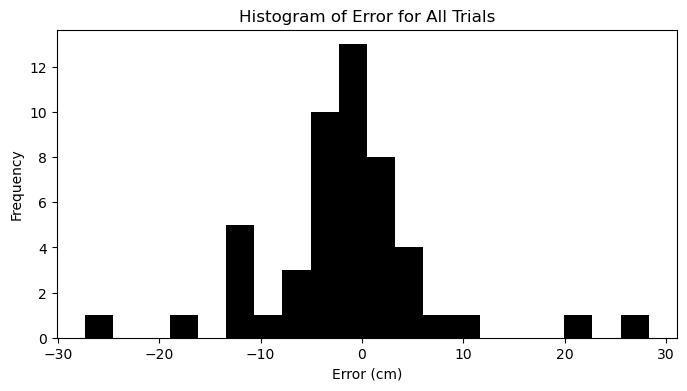

In [38]:
# Plot a histogram of error for the df
# Convert error to cm from m
df['error_cm'] = df['error'] * 100
plt.figure(figsize=(8, 4))
plt.hist(df['error_cm'], bins=20, label='Error (cm)', color ='black')
plt.xlabel('Error (cm)')
plt.ylabel('Frequency')
plt.title('Histogram of Error for All Trials')
plt.show()

In [39]:
# Get standard deviation of physical height
physical_height_std = df['physical_height'].std()
print('Standard Deviation of Physical Height: {}'.format(physical_height_std))
# Get standard deviation of sensor height
sensor_height_std = df['sensor_height'].std()
print('Standard Deviation of Sensor Height: {}'.format(sensor_height_std))

Standard Deviation of Physical Height: 0.18789532474552018
Standard Deviation of Sensor Height: 0.1692622897799962


In [40]:
# add columns for physical height and sensor height in cm
df['physical_height_cm'] = df['physical_height'] * 100
df['sensor_height_cm'] = df['sensor_height'] * 100

In [41]:
# Get regression line for physical height and sensor height
def linear_model(x, a, b):
				return a * x + b

seed =	42
random.seed(seed)
# train-test-split the data
X_train, X_test, y_train, y_test = train_test_split(df['physical_height_cm'], df['sensor_height_cm'], test_size=0.2, random_state=seed)
#	Fit the model to the training data
popt, pcov = curve_fit(linear_model, X_train, y_train)
# Get the slope and intercept of the regression line
a, b = popt
print('Slope: {}'.format(a))
print('Intercept: {}'.format(b))
# Get the predicted values for the test set
y_pred = linear_model(X_test, a, b)
# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)
print('R-squared: {}'.format(r2))
# Calculate the RMSE for the test set
rmse_test = rmse(y_pred, y_test)
print('RMSE for Test Set: {}'.format(rmse_test))
# Calculate the RRMSE for the test set
rrmse_test = rrmse(y_pred, y_test)
print('RRMSE for Test Set: {}'.format(rrmse_test))


Slope: 0.8014054501300937
Intercept: 13.578170781226756
R-squared: 0.951505592430945
RMSE for Test Set: 4.667022800286733
RRMSE for Test Set: 0.05717708977184658


In [60]:
print(df.columns)

Index(['Record', 'Trial', 'Collection Date', 'Collection Level', 'plot_id',
       'date_dir', 'trial_dir', 'sensor_height', 'error', 'physical_height',
       'percent_error', 'error_cm', 'physical_height_cm', 'sensor_height_cm',
       'growth_pattern', 'corrected_sensor_height', 'corrected_error',
       'corrected_percent_error'],
      dtype='object')


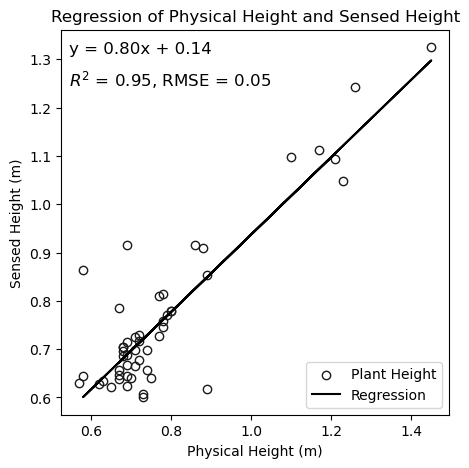

In [71]:
# Plot the regression line
plt.figure(figsize=(5, 5))
facecolor_translucent = (0.1, 0.1, 0.1, 0.001)
edgecolor_translucent = (0.1, 0.1, 0.1, 1)
plt.scatter(df['physical_height'], df['sensor_height'], label='Plant Height', facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
plt.plot(X_test/100, y_pred/100, label='Regression', color='black')
plt.xlabel('Physical Height (m)')
plt.ylabel('Sensed Height (m)')
plt.title('Regression of Physical Height and Sensed Height')
plt.legend(loc='lower right')
# add equation	to the plot
plt.text(0.02, 0.97, 'y = {:.2f}x + {:.2f}'.format(a, b), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.02, 0.90, '$R^2$ = {r2s:.2f}, RMSE = {rmses:.2f}'.format(r2s=r2, rmses=rmse_test/100), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# save the plot
plt.savefig('plot_figs/regression_physical_vs_sensed_height.png', dpi=300, bbox_inches='tight')

In [43]:
# Calculate smape
def smape(y_true, y_pred):
				return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
print('SMAPE: {}'.format(smape(df['physical_height_cm'], df['sensor_height_cm'])))

SMAPE: 7.50254432783198


# Additional Analyses To Do
1. Check to see if linear regression correction applied to the whole set improves sensor performance.
2. Check to see if determinate vs indeterminate distributions differ.

In [44]:
# Identify the growth patterns of the plants
ind = ["05", "01", "16", "19", "20"]
# Add a new column to the df for the growth pattern
df['growth_pattern'] = np.nan
# Assign the growth pattern to the df
df.loc[df['plot_id'].isin(ind), 'growth_pattern'] = 'indeterminate'
df_ind = df.loc[df['growth_pattern'] == 'indeterminate']
df.loc[~df['plot_id'].isin(ind), 'growth_pattern'] = 'determinate'
df_det = df.loc[df['growth_pattern'] == 'determinate']

In [45]:
# Calculate the mean and standard deviation for each metric for each df
def calculate_stats(df):
    # Calculate the mean and standard deviation for each metric
				mean_sensor_height = df['sensor_height'].mean()
				std_sensor_height = df['sensor_height'].std()
				mean_physical_height = df['physical_height'].mean()
				std_physical_height = df['physical_height'].std()
				mean_error = df['error'].mean()
				std_error = df['error'].std()
				mean_percent_error = df['percent_error'].mean()
				std_percent_error = df['percent_error'].std()

				return mean_sensor_height, std_sensor_height, mean_physical_height, std_physical_height, mean_error, std_error, mean_percent_error, std_percent_error
# Calculate the stats for the indeterminate growth pattern
ind_stats = calculate_stats(df_ind)
print('Indeterminate Growth Pattern Stats:')
print('Mean Sensor Height: {}'.format(ind_stats[0]))
print('Standard Deviation Sensor Height: {}'.format(ind_stats[1]))
print('Mean Physical Height: {}'.format(ind_stats[2]))
print('Standard Deviation Physical Height: {}'.format(ind_stats[3]))
print('Mean Error: {}'.format(ind_stats[4]))
print('Standard Deviation Error: {}'.format(ind_stats[5]))
print('Mean Percent Error: {}'.format(ind_stats[6]))
print('Standard Deviation Percent Error: {}'.format(ind_stats[7]))
# Calculate the stats for the determinate growth pattern
det_stats = calculate_stats(df_det)
print('Determinate Growth Pattern Stats:')
print('Mean Sensor Height: {}'.format(det_stats[0]))
print('Standard Deviation Sensor Height: {}'.format(det_stats[1]))
print('Mean Physical Height: {}'.format(det_stats[2]))
print('Standard Deviation Physical Height: {}'.format(det_stats[3]))
print('Mean Error: {}'.format(det_stats[4]))
print('Standard Deviation Error: {}'.format(det_stats[5]))
print('Mean Percent Error: {}'.format(det_stats[6]))
print('Standard Deviation Percent Error: {}'.format(det_stats[7]))

Indeterminate Growth Pattern Stats:
Mean Sensor Height: 1.119040003491682
Standard Deviation Sensor Height: 0.07334428330939771
Mean Physical Height: 1.194
Standard Deviation Physical Height: 0.06188699378706318
Mean Error: -0.074959996508318
Standard Deviation Error: 0.07397827750455431
Mean Percent Error: -6.172563557628265
Standard Deviation Percent Error: 6.022315162928734
Determinate Growth Pattern Stats:
Mean Sensor Height: 0.7255488885404904
Standard Deviation Sensor Height: 0.12482353178180211
Mean Physical Height: 0.7353333333333334
Standard Deviation Physical Height: 0.13210877061242857
Mean Error: -0.009784444792842904
Standard Deviation Error: 0.08569896552677607
Mean Percent Error: -0.6329194863710751
Standard Deviation Percent Error: 12.207459446182796


In [46]:
# check for normality	of the physical height distribution for the indeterminate growth pattern
shapiro_ind = shapiro(df_ind['physical_height'])
print('Shapiro-Wilk test for Indeterminate Growth Pattern: W = {}, p-value = {}'.format(shapiro_ind.statistic, shapiro_ind.pvalue))
# check	normality of the physical height distribution for the determinate growth pattern using Shapiro-Wilk test
shapiro_det = shapiro(df_det['physical_height'])
print('Shapiro-Wilk test for Determinate Growth Pattern: W = {}, p-value = {}'.format(shapiro_det.statistic, shapiro_det.pvalue))

Shapiro-Wilk test for Indeterminate Growth Pattern: W = 0.9528988599777222, p-value = 0.7578733563423157
Shapiro-Wilk test for Determinate Growth Pattern: W = 0.6618276834487915, p-value = 6.411157826846647e-09


In [47]:
# check normality of the sensor height distribution for the indeterminate growth pattern
shapiro_ind_sensor = shapiro(df_ind['sensor_height'])
print('Shapiro-Wilk test for Indeterminate Growth Pattern Sensor Height: W = {}, p-value = {}'.format(shapiro_ind_sensor.statistic, shapiro_ind_sensor.pvalue))
# check normality of the sensor height distribution for the determinate growth pattern using Shapiro-Wilk test
shapiro_det_sensor = shapiro(df_det['sensor_height'])
print('Shapiro-Wilk test for Determinate Growth Pattern Sensor Height: W = {}, p-value = {}'.format(shapiro_det_sensor.statistic, shapiro_det_sensor.pvalue))

Shapiro-Wilk test for Indeterminate Growth Pattern Sensor Height: W = 0.8333907723426819, p-value = 0.1474655419588089
Shapiro-Wilk test for Determinate Growth Pattern Sensor Height: W = 0.7462801933288574, p-value = 1.8924163214251166e-07


In [48]:
# check normality of the error distribution for the indeterminate growth pattern using Shapiro-Wilk test
shapiro_ind_error = shapiro(df_ind['error'])
print('Shapiro-Wilk test for Indeterminate Growth Pattern Error: W = {}, p-value = {}'.format(shapiro_ind_error.statistic, shapiro_ind_error.pvalue))
# check normality of the error distribution for the determinate growth pattern using Shapiro-Wilk test
shapiro_det_error = shapiro(df_det['error'])
print('Shapiro-Wilk test for Determinate Growth Pattern Error: W = {}, p-value = {}'.format(shapiro_det_error.statistic, shapiro_det_error.pvalue))

Shapiro-Wilk test for Indeterminate Growth Pattern Error: W = 0.9273165464401245, p-value = 0.5781888961791992
Shapiro-Wilk test for Determinate Growth Pattern Error: W = 0.8787291646003723, p-value = 0.0002199106675107032


In [49]:
# check normality of percent	error distribution for the indeterminate growth pattern using Shapiro-Wilk test
shapiro_ind_percent_error = shapiro(df_ind['percent_error'])
print('Shapiro-Wilk test for Indeterminate Growth Pattern Percent Error: W = {}, p-value = {}'.format(shapiro_ind_percent_error.statistic, shapiro_ind_percent_error.pvalue))
# check normality of percent error distribution for the determinate growth pattern using Shapiro-Wilk test
shapiro_det_percent_error = shapiro(df_det['percent_error'])
print('Shapiro-Wilk test for Determinate Growth Pattern Percent Error: W = {}, p-value = {}'.format(shapiro_det_percent_error.statistic, shapiro_det_percent_error.pvalue))

Shapiro-Wilk test for Indeterminate Growth Pattern Percent Error: W = 0.9290477633476257, p-value = 0.5898913145065308
Shapiro-Wilk test for Determinate Growth Pattern Percent Error: W = 0.8375377058982849, p-value = 1.777101897459943e-05


Recap:
1. Indeterminate physical height was normally distributed, determinate was non-normally distributed.
2. Indeterminate sensed height was normally distributed, determinate was non-normally distributed.
3. Indeterminate error was normally distributed, determinate was non-normally distributed.
4. Indeterminate percent error was normally distributed, determinate was non-normally distributed.

The distributions for all pairs included at least one abnormal distribution. Therefore, we must use a Mann-Whitney U test to determine if they are significantly different.

In [50]:
# run a mann-whitney u test for the physical height of both growth patterns
u_stat, p_value = mannwhitneyu(df_ind['physical_height'], df_det['physical_height'], alternative='two-sided')
print('Mann-Whitney U test for Physical Height: U-statistic = {}, p-value = {}'.format(u_stat, p_value))
# run a mann-whitney u test for the sensor height of both growth patterns
u_stat, p_value = mannwhitneyu(df_ind['sensor_height'], df_det['sensor_height'], alternative='two-sided')
print('Mann-Whitney U test for Sensor Height: U-statistic = {}, p-value = {}'.format(u_stat, p_value))
# run a mann-whitney u test for the error of both growth patterns
u_stat, p_value = mannwhitneyu(df_ind['error'], df_det['error'], alternative='two-sided')
print('Mann-Whitney U test for Error: U-statistic = {}, p-value = {}'.format(u_stat, p_value))
# run a mann-whitney u test for the percent error of both growth patterns
u_stat, p_value = mannwhitneyu(df_ind['percent_error'], df_det['percent_error'], alternative='two-sided')
print('Mann-Whitney U test for Percent Error: U-statistic = {}, p-value = {}'.format(u_stat, p_value))

Mann-Whitney U test for Physical Height: U-statistic = 220.0, p-value = 0.0005277613789831627
Mann-Whitney U test for Sensor Height: U-statistic = 220.0, p-value = 0.0005396580646780341
Mann-Whitney U test for Error: U-statistic = 62.0, p-value = 0.10752893201684005
Mann-Whitney U test for Percent Error: U-statistic = 74.0, p-value = 0.2267930298854047


Sensed and physical height differ between the two growth, but error and percent error does not. It makes sense, as the plants with different growth patterns were definitely different in height, so their sensed height should be different as well. Error was always within a couple cm, so that was not going to be too different between the two growth patterns. Percent error, likewise, did not differ. This tells us that while plant height may differ (within reasonable bounds), the error will be similar. Thus, we can combine them into an overall dataset without losing any granular details about sensor performance.

In [51]:
# Create a column for corrected sensor height
a = 0.8
b = 0.14
def correct(x, a, b):
	return (x-b)/a
df['corrected_sensor_height'] = df['sensor_height'].apply(lambda x: correct(x, a, b))
# Calculate the RMSE for the corrected sensor height
corrected_rmse = rmse(df['corrected_sensor_height'], df['physical_height'])
print('Corrected RMSE: {}'.format(corrected_rmse))
# Calculate the RRMSE for the corrected sensor height
corrected_rrmse = rrmse(df['corrected_sensor_height'], df['physical_height'])
print('Corrected RRMSE: {}'.format(corrected_rrmse))

Corrected RMSE: 0.09606377841104875
Corrected RRMSE: 0.12296950641455294


In [52]:
# Get rmse for sensor height and physical height
rmse = rmse(df['sensor_height'], df['physical_height'])
print('RMSE: {}'.format(rmse))
# Get rrmse for sensor height and physical height
rrmse = rrmse(df['sensor_height'], df['physical_height'])
print('RRMSE: {}'.format(rrmse))

RMSE: 0.08688429054924802
RRMSE: 0.11121900991967233


In [53]:
# print mean	and standard deviation of the corrected sensor height
corrected_mean = df['corrected_sensor_height'].mean()
print('Corrected Mean: {}'.format(corrected_mean))
corrected_std = df['corrected_sensor_height'].std()
print('Corrected Standard Deviation: {}'.format(corrected_std))

Corrected Mean: 0.781122500044512
Corrected Standard Deviation: 0.21157786222499522


In [54]:
# print mean and standard deviation of the physical height
physical_mean = df['physical_height'].mean()
print('Physical Mean: {}'.format(physical_mean))
physical_std = df['physical_height'].std()
print('Physical Standard Deviation: {}'.format(physical_std))

Physical Mean: 0.7812
Physical Standard Deviation: 0.18789532474552018


In [55]:
# print mean and standard deviation of the sensor height
sensor_mean = df['sensor_height'].mean()
print('Sensor Mean: {}'.format(sensor_mean))
sensor_std = df['sensor_height'].std()
print('Sensor Standard Deviation: {}'.format(sensor_std))

Sensor Mean: 0.7648980000356096
Sensor Standard Deviation: 0.1692622897799962


In [56]:
# conduct shapiro-wilk test for the corrected sensor height and skewness test
shapiro_corrected = shapiro(df['corrected_sensor_height'])
print('Shapiro-Wilk test for Corrected Sensor Height: W = {}, p-value = {}'.format(shapiro_corrected.statistic, shapiro_corrected.pvalue))
# run skewness test
skew_corrected = skewtest(df['corrected_sensor_height'])
print('Skewness test for Corrected Sensor Height: statistic = {}, p-value = {}'.format(skew_corrected.statistic, skew_corrected.pvalue))

Shapiro-Wilk test for Corrected Sensor Height: W = 0.7937440872192383, p-value = 6.310627327366092e-07
Skewness test for Corrected Sensor Height: statistic = 4.11585956550698, p-value = 3.8573913101430334e-05


The correction equation produced a non-normal distribution with skew, so Mann-Whitney U tests will be used to determine whether it is significantly different from the physical height and sensed height.

In [57]:
# conduct a Mann-Whitney U test for the corrected sensor height and physical height
u_stat, p_value = mannwhitneyu(df['corrected_sensor_height'], df['physical_height'], alternative='two-sided')
print('Mann-Whitney U test for Corrected Sensor Height and Physical Height: U-statistic = {}, p-value = {}'.format(u_stat, p_value))

Mann-Whitney U test for Corrected Sensor Height and Physical Height: U-statistic = 1151.0, p-value = 0.4970161710955491


In [58]:
# conduct a Mann-Whitney U	test for the corrected sensor height and sensor height
u_stat, p_value = mannwhitneyu(df['corrected_sensor_height'], df['sensor_height'], alternative='two-sided')
print('Mann-Whitney U test for Corrected Sensor Height and Sensor Height: U-statistic = {}, p-value = {}'.format(u_stat, p_value))

Mann-Whitney U test for Corrected Sensor Height and Sensor Height: U-statistic = 1220.0, p-value = 0.8388467008580135


In [59]:
# Add a column for corrected error
df['corrected_error'] = df['corrected_sensor_height'] - df['physical_height']
# Add a column for	corrected percent error
df['corrected_percent_error'] = df['corrected_error'] / df['physical_height'] * 100
# Calculate the mean and standard deviation of the corrected error
corrected_error_mean = df['corrected_error'].mean()
print('Corrected Error Mean: {}'.format(corrected_error_mean))
corrected_error_std = df['corrected_error'].std()
print('Corrected Error Standard Deviation: {}'.format(corrected_error_std))
# Calculate the mean and standard deviation of the corrected percent error
corrected_percent_error_mean = df['corrected_percent_error'].mean()
print('Corrected Percent Error Mean: {}'.format(corrected_percent_error_mean))
corrected_percent_error_std = df['corrected_percent_error'].std()
print('Corrected Percent Error Standard Deviation: {}'.format(corrected_percent_error_std))
# calculate mean and standard deviation of error
error_mean = df['error'].mean()
print('Error Mean: {}'.format(error_mean))
error_std = df['error'].std()
print('Error Standard Deviation: {}'.format(error_std))
# calculate mean and standard deviation of percent error
percent_error_mean = df['percent_error'].mean()
print('Percent Error Mean: {}'.format(percent_error_mean))
percent_error_std = df['percent_error'].std()
print('Percent Error Standard Deviation: {}'.format(percent_error_std))

Corrected Error Mean: -7.749995548806954e-05
Corrected Error Standard Deviation: 0.09703903862208206
Corrected Percent Error Mean: 0.1615560964778171
Corrected Percent Error Standard Deviation: 13.608627008009178
Error Mean: -0.016301999964390412
Error Standard Deviation: 0.08620765592574359
Percent Error Mean: -1.1868838934967942
Percent Error Standard Deviation: 11.815018532617131
